In [1]:
import random
import os
import sys
sys.path.append("..")
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
import numpy as np

from src.models.ganconv import *
from src.train.trainer.TrainerGAN import Trainer
from src.data.preprocessing.pipeline import Pipeline
from src.data.datasets.universal_dataset import CVADataset
from src.data.preprocessing.splitter import select_test_inh

from src.utils.paths import get_project_path

In [2]:
torch.manual_seed(42)
np.random.seed(42)

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [3]:
prep = Pipeline(
    num_cycle=[1, 2, 3, 4], 
    inhibitor_name="all", 
    split="all",
    norm_feat=True
)

df = prep.full_data

train, val = select_test_inh(df, "benzimidazole")

In [4]:
train_dataset = CVADataset(train)
test_dataset = CVADataset(val)

train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(test_dataset, batch_size=256, shuffle=True)

In [ ]:
input_dim=80
output_vah = len(prep.cur_orig.columns)

generator = Generator(in_dim=input_dim, vah_dim=output_vah, desc_dim=41).to(device)
discriminator = Discriminator(output_vah).to(device)

optimizer_G = torch.optim.Adam(generator.parameters(), lr=1e-4, betas=(0.99, 0.899))
optimizer_D = torch.optim.Adam(discriminator.parameters(), lr=1e-5, betas=(0.99, 0.999))


criterion = nn.BCELoss(reduction='sum')
recon_loss = nn.L1Loss(reduction="sum")

num_epochs=5

trainer = Trainer(
    generator=generator,
    discriminator=discriminator,
    loss_fn=criterion,
    loss_recon=recon_loss,
    epochs=num_epochs,
    optimizer_gen=optimizer_G,
    optimizer_disc=optimizer_D,
    train_loader=train_loader,
    val_loader=val_loader,
    device=device,
    path_to_save_plots=os.path.join(get_project_path(), "reports", "gan_conv", "benzimidazole"),
    path_to_save_models=os.path.join(get_project_path(), "models", "gan_conv", "benzimidazole"),
    path_to_save_tables=os.path.join(get_project_path(), "reports", "gan_conv", "benzimidazole"),
    seed=42
)

In [6]:
trainer.train_model()

Epoch [000] | D Loss: 370.5393(331.8948) | G Loss: 14175.5171(10974.0615) 
Epoch [001] | D Loss: 345.2271(312.1476) | G Loss: 12720.3817(11751.8628) 
Epoch [002] | D Loss: 333.9555(296.4206) | G Loss: 11530.3479(11363.2737) 
Epoch [003] | D Loss: 334.4274(296.0639) | G Loss: 10471.4875(10544.6971) 
Epoch [004] | D Loss: 341.9825(301.9903) | G Loss: 9567.8135(9680.0856) 


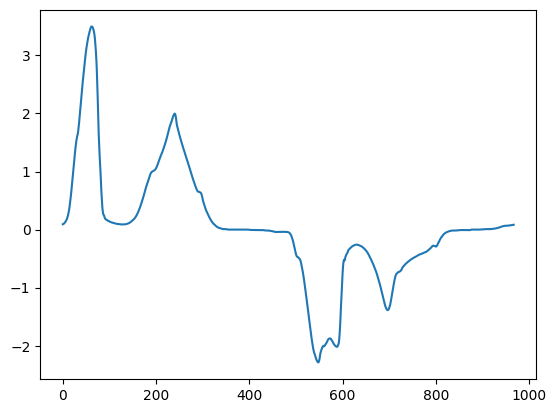

In [14]:
plt.plot(real_vah.detach().cpu().numpy()[0])

In [42]:
full_ds = CVADataset(val)
infer_loader = DataLoader(full_ds, batch_size=1, shuffle=False)

vahh = []

generator.eval()
with torch.no_grad():
    for val_batch in infer_loader:
        real_features = val_batch['features'].to(device)
        real_vah = val_batch['vah'].to(device)
        batch_size = real_vah.size(0)
        z = torch.randn(batch_size, input_dim).to(device)
        
        gen_vah = generator(z.unsqueeze(1), real_features.unsqueeze(1))
        vahh.append(gen_vah.detach().cpu().numpy()[0])
        
df_vah = pd.DataFrame(vahh)
df_vah["Inhibitor"] = val.reset_index(drop=True)["Inhibitor"]

In [43]:
from dtaidistance import dtw

def compute_dtw(original, reconstructed):
    """
    Dynamic Time Warping расстояние между временными рядами.
    """
    return dtw.distance_fast(original, reconstructed, use_c = True)

In [44]:
np_vah = np.array(df_vah.drop(columns=["Inhibitor"]), dtype=np.float64)
np_valid = np.array(val.drop(columns=prep.desc.columns).drop(columns=["ppm"]), dtype=np.float64)

In [45]:
from tqdm import tqdm

dtw_m = []

for i in tqdm(range(len(df_vah))):
    dtw_m.append(compute_dtw(np_vah[i], np_valid[i]))

100%|██████████| 940/940 [00:03<00:00, 283.41it/s]


In [46]:
metr = pd.DataFrame({
    "Inhibitor": val.reset_index(drop=True)["Inhibitor"],
    "metrics":dtw_m})

In [47]:
metr['Inhibitor'].unique()

array(['benzimidazole'], dtype=object)

In [48]:
metr['metrics'].mean()

9.975855097043484

In [49]:
metr.to_csv("gan_benzimidazole.csv", index=False)

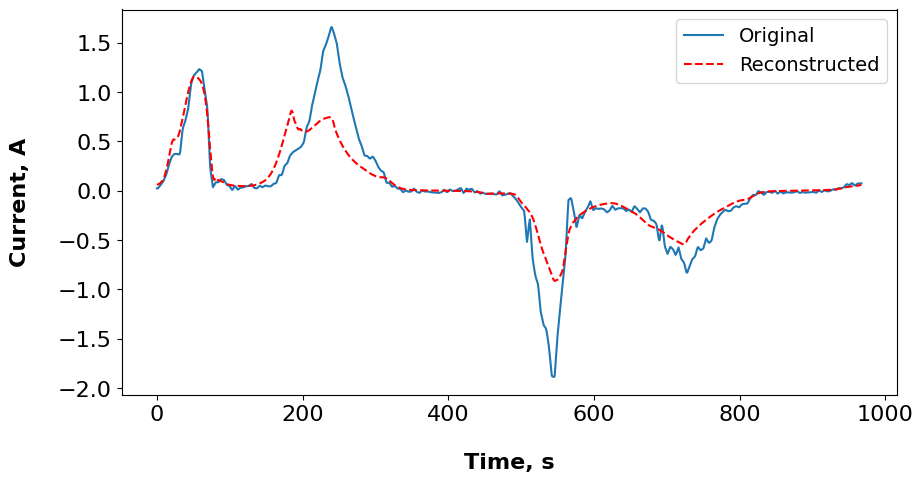

In [50]:
n = 3

plt.figure(figsize=(10, 5))
plt.plot(np_vah[n], label="Original")
plt.plot(np_valid[n], label="Reconstructed", linestyle='--', color='red')
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlabel("Time, s", fontsize=16, fontweight='bold', labelpad=20)
plt.ylabel("Current, A", fontsize=16, fontweight='bold', labelpad=20)
plt.legend(fontsize=14, )
plt.show()